In [4]:
import g2o
import scipy
import numpy as np
import matplotlib.pyplot as plt

from icp import icp
from graph import Graph
from dataset_intel import Dataset_intel

In [7]:
# Parameters
max_iterations = 4000
thres = 0.15
lc_num = 0

max_x = -float('inf')
max_y = -float('inf')
min_x = float('inf')
min_y = float('inf')

# Load dataset
odoms_laser, lasers = Dataset_intel('data').get_dataset()

# Create graph
graph = Graph()

# Initial state
pose = np.eye(3)
id = 0
graph.add_vertex(id, g2o.SE2(g2o.Isometry2d(pose)), fixed=True)

init_pose = np.eye(3)
vertex_idx = 1
registered_lasers = []
registered_idxs = []
registered_lasers.append(lasers[0])
registered_idxs.append(0)
vertex_id_odom_idx = []

# add odom to graph
for odom_idx, odom in enumerate(odoms_laser):
    if odom_idx==max_iterations:
        break
    if odom_idx==0:
        prev_odom = odom[odom_idx].copy()
        prev_idx = 0
        continue

    # Check if the pose moved
    do = odom - prev_odom
    if np.linalg.norm(do[:2])>0.4 or abs(do[2])>0.2:

        # (2, 180)
        A = lasers[prev_idx]
        B = lasers[odom_idx]
        registered_lasers.append(B)
        registered_idxs.append(odom_idx)
        dx, dy, dtheta = do[0], do[1], do[2]
        init_pose = np.array([[np.cos(dtheta), -np.sin(dtheta), dx], [np.sin(dtheta), np.cos(dtheta), dy],[0, 0, 1]])
        with np.errstate(all='raise'):
            try:
                T, distances, iterations,information = icp(B.T, A.T, init_pose, max_iterations=80, tolerance=0.0001)

            except Exception as e:
                print(odom_idx, e, A.shape, B.shape)
                assert 1==0
                continue
        
        # Update the pose
        pose = np.matmul(pose, T)
        graph.add_vertex(vertex_idx, g2o.SE2(g2o.Isometry2d(pose)))
        vertex_id_odom_idx.append(odom_idx)

        rk = g2o.RobustKernelDCS()

        graph.add_edge([vertex_idx-1, vertex_idx],
                                 g2o.SE2(g2o.Isometry2d(T)),
                                 information, robust_kernel=rk)
        
        # Update
        prev_odom = odom
        prev_idx = odom_idx

        # Loop closure
        if vertex_idx > 10 and not vertex_idx % 10:
            poses = [graph.get_pose(idx).to_vector()[:2] for idx in range(vertex_idx-1)]

            kd = scipy.spatial.cKDTree(poses)
            x, y, theta = graph.get_pose(vertex_idx).to_vector()
            direction = np.array([np.cos(theta), np.sin(theta)])
            idxs = kd.query_ball_point(np.array([x,y]), r=4.25, p=2.)
            for idx in idxs:
                A = registered_lasers[idx]
                with np.errstate(all='raise'):
                    try:
                        T, distances, iterations, information = icp(A.T, B.T, np.eye(3), max_iterations=80, tolerance=0.0001)

                    except Exception as e:
                        print(odom_idx, e, A.shape, B.shape)
                        continue

                if np.mean(distances) < thres:
                    dist = np.linalg.norm(T[:2,2])
                    print(f'odom_idx: {odom_idx}, vertex_idx: {vertex_idx}, lc_num: {lc_num}, dist: {dist}, Edge added.')
                    lc_num+=1

                    rk = g2o.RobustKernelDCS()
                    graph.add_edge([vertex_idx, idx], g2o.SE2(g2o.Isometry2d(T)), information, robust_kernel=rk)

            graph.optimize()
            pose = graph.get_pose(vertex_idx).to_isometry().matrix()

        vertex_idx+=1

odom_idx: 290, vertex_idx: 30, lc_num: 0, dist: 0.3343639874535775, Edge added.
odom_idx: 290, vertex_idx: 30, lc_num: 1, dist: 0.2714941338117957, Edge added.
odom_idx: 290, vertex_idx: 30, lc_num: 2, dist: 0.18690658459643966, Edge added.
odom_idx: 290, vertex_idx: 30, lc_num: 3, dist: 0.15590532563495646, Edge added.
odom_idx: 290, vertex_idx: 30, lc_num: 4, dist: 0.1719612315722028, Edge added.
odom_idx: 290, vertex_idx: 30, lc_num: 5, dist: 0.1535100144254976, Edge added.
odom_idx: 290, vertex_idx: 30, lc_num: 6, dist: 0.08587649062186609, Edge added.
odom_idx: 670, vertex_idx: 80, lc_num: 7, dist: 0.26214506772589685, Edge added.
odom_idx: 913, vertex_idx: 110, lc_num: 8, dist: 0.07434613864397928, Edge added.
odom_idx: 972, vertex_idx: 120, lc_num: 9, dist: 0.3255826531204507, Edge added.
odom_idx: 1042, vertex_idx: 130, lc_num: 10, dist: 0.3631313383088991, Edge added.
odom_idx: 1486, vertex_idx: 190, lc_num: 11, dist: 0.2882868358639616, Edge added.
odom_idx: 1486, vertex_idx:

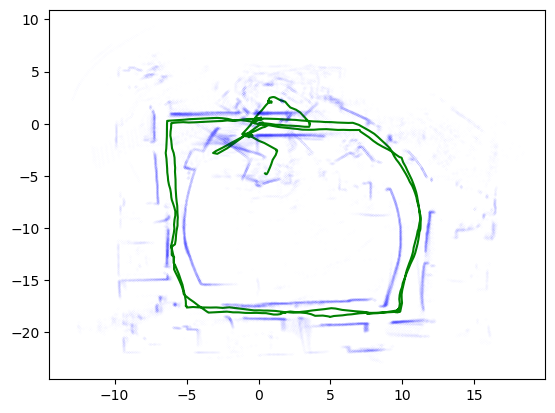

In [8]:
graph.plot(num_vertex=vertex_idx, registered_lasers=registered_lasers, show_point_cloud=True)